In [1]:
from __future__ import print_function, absolute_import, division
import os, glob, sys
from skimage.io import imread, imshow, imsave
import numpy as np
import matplotlib.pyplot as plt
import cityscapesscripts
import tensorflow as tf
tf.device('/device:GPU:2')

def getData(num_tests, start, train=True):
#     if 'CITYSCAPES_DATASET' in os.environ:
#         cityscapesPath = os.environ['CITYSCAPES_DATASET']
#     else:
#         cityscapesPath = os.path.join(os.path.dirname(os.path.realpath(__file__)), '..', '..')
    cityscapesPath = '../../rvygon_data'
    searchAnnotated = os.path.join(cityscapesPath, "gtFine", "train", "*", "*_gt*_labelTrain*")
    searchRaw = os.path.join(cityscapesPath, "leftImg8bit", "train", "*", "*.png")

    if not searchAnnotated:
        printError("Did not find any annotated files.")
    filesAnnotated =glob.glob(searchAnnotated)

    filesRaw=glob.glob(searchRaw)
    filesAnnotated.sort()
    filesRaw.sort()

    """
    edit files so that filesAnnotated and filesRaw are the same shape and correspond to each other
    """
    return filesAnnotated[start:start+num_tests], filesRaw[start:start+num_tests]

def importBatch(num_tests, start):   #load batch of data from train dataset
    y_files, X_files = getData(num_tests,start)
    X_input = []
    y_input = []
    k = 0
    for i in range(len(X_files)):

        y_file = y_files[i+k]
        X_file = X_files[i]

        while (y_file.split('/')[7][:-25] != X_file.split('/')[7][:-16]):
            k+=1
            y_file = y_files[i+k]

        X_img = imread(X_file)
        y_img = imread(y_file)

        X_input.append(X_img)
        y_input.append(y_img)

    X = np.array(X_input)
    y = np.array(y_input)
    return X, y
def initTrain():
    import cityscapesscripts.preparation.createTrainIdLabelImgs
    import cityscapesscripts.preparation.createTrainIdInstanceImgs

In [2]:
import numpy as np
from keras.utils import to_categorical

def preprocess_pic(X, y):
    y[y==255]=19
    y=to_categorical(y)
    return X, y

def keras_generator(batch_size, max_iterations=1e9, train=True):
    num_iterations = 0
    while True:
        if num_iterations >= max_iterations:
            break
        batch_nums = np.random.randint(low=1000, high=2000, size=batch_size)
        batch_input = []
        batch_output = []
        
        for index in batch_nums:
            input_labels, input_images = getData(1, index)
            input_image = input_images[0]
            input_label = input_labels[0]           
            
            X_img = imread(input_image)
            y_img = imread(input_label)
            
            X_img, y_img = preprocess_pic(X_img, y_img)
            
            batch_input.append(X_img)
            batch_output.append(y_img)
            
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output) 
        
        num_iterations += 1
        yield batch_x, batch_y

Using TensorFlow backend.


In [3]:
# %%bash
# python cityscapesscripts/preparation/createTrainIdLabelImgs.py
# python cityscapesscripts/preparation/createTrainIdInstanceImgs.py

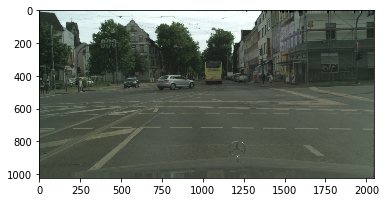

In [17]:
for X, y in keras_generator(1, 1):
    plt.imshow(X[0])
    
plt.show()

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
# import cv2
import os
import random
from functools import partial

In [22]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [23]:
K.set_image_dim_ordering('tf')
print(K.image_data_format())

channels_last


In [24]:
def Generator(size, num_classes):
    def Down(in_layer, num_filters, padding='same', kernel_size=(3, 3), pool_size=(2, 2), normalize=True):
        in_layer = Conv2D(num_filters, kernel_size, padding=padding)(in_layer)
        if normalize:
            in_layer = BatchNormalization()(in_layer)
        in_layer = LeakyReLU()(in_layer)
        in_layer = Conv2D(num_filters, kernel_size, padding=padding)(in_layer)
        if normalize:
            in_layer = BatchNormalization()(in_layer)
        in_layer = LeakyReLU()(in_layer)
        in_layer = MaxPooling2D(pool_size=pool_size)(in_layer)
        return in_layer
    def Up(in_layer, concat_layer, num_filters, padding='same', kernel_size=(3, 3), pool_size=(2, 2), normalize=True):
        # interpolation nearest ???
        in_layer = Concatenate(axis=3)([UpSampling2D(size=pool_size)(in_layer), concat_layer])
        in_layer = Conv2D(num_filters, kernel_size, padding=padding)(in_layer)
        if normalize:
            in_layer = BatchNormalization()(in_layer)
        in_layer = LeakyReLU()(in_layer)
        in_layer = Conv2D(num_filters, kernel_size, padding=padding)(in_layer)
        if normalize:
            in_layer = BatchNormalization()(in_layer)
        in_layer = LeakyReLU()(in_layer)
        return in_layer
    
    inputs = Input((1024, 2048, 3))
    normalized = BatchNormalization()(inputs)
    
    conv1 = Down(normalized, 32)
    conv2 = Down(conv1, 64)
    conv3 = Down(conv2, 128)
    
    conv4 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU()(conv4)
    up4 = MaxPooling2D((2, 2))(conv4)
    conv5 = Conv2D(512, (3, 3), padding='same')(up4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU()(conv5)
    
    up5 = MaxPooling2D((2, 2))(conv5)
    conv6 = Conv2D(1024, (3, 3), padding='same')(up5)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(1024, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU()(conv6)
    
    up3 = Up(conv6, conv5, 512)
    up2 = Up(up3, conv3, 256)
    up1 = Up(up2, conv2, 128)
    outputs = Up(up1, conv1, 64)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(outputs)
    
    
    model = Model(inputs=inputs, outputs=outputs)
    print(type(model))
    return model        

In [25]:
model = Generator(size=256, num_classes=20)

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(adam, 'categorical_crossentropy')

<class 'keras.engine.training.Model'>


In [26]:
best_w = ModelCheckpoint('unet_best.h5',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)
last_w = ModelCheckpoint('unet_last.h5',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

callbacks = [best_w, last_w]

In [94]:
batch_size = 16
model.fit_generator(keras_generator(batch_size, train=True),
                    steps_per_epoch=100,
                    epochs=3,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=keras_generator(batch_size, train=False),
                    validation_steps=50,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)


Epoch 1/3


ValueError: Error when checking target: expected conv2d_257 to have shape (512, 1024, 20) but got array with shape (1024, 2048, 20)

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 2048, 3 0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024, 2048, 3 12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 2048, 3 896         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 1024, 2048, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

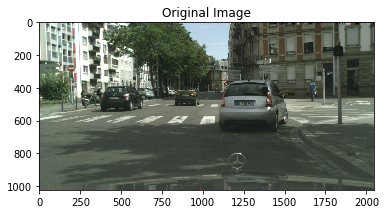

In [4]:
for X, y in keras_generator(1, 1):
        plt.imshow(X[0])
        plt.title("Original Image")
    
plt.show()

In [15]:
img_shape = (256, 512, 3)
batch_size = 1
import functools

In [6]:
def shifted_image(image, label, width_shift_range, height_shift_range):
    """horisontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        image = tf.contrib.image.translate(image, [width_shift_range, height_shift_range])
        label = tf.contrib.image.translate(label, [width_shit_range, height_shift_range])
    return image, label
            

In [7]:
def flip_img(horizontal_flip, image, label):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                   lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                                   lambda: (image, label))
    return image, label

In [10]:
def crop_img(crop_size, image, label):
    if crop_size is not None:
        image = tf.random_crop(image, [crop_size[0], crop_size[0], 3])
        label = tf.random_crop(image, [crop_size[0], crop_size[0], 20])
        # TODO resize to initial size 
    return image, label

In [11]:
def _augment(image,
             label,
             resize=None,
             hue_delta=0,
             horizontal_flip=False,
             width_shift_range=0,
             height_shift_range=0,
             crop_size=None):
    if resize is not None:
        label = tf.image.resize_images(label, resize)
        image = tf.image.resize_images(image, resize)
    if hue_delta:
        image = tf.image.random_hue(image, resize)
    
    image, label = flip_img(horisontal_flip, image, label)
    image, label = shifted_image(image, label, width_shift_range, height_shift_range)
    return image, label

In [ ]:
def to_tensor(image, label):
    return image, label

In [16]:
def get_dataset(images, labels,
                preproc_fn=functools.partial(_augment),
                threads=5,
                batch_size=batch_size,
                shuffle=True):
    num_x = len(images)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(to_tensors, num_parallel_calls=threads)
    
    if shuffle:
        dataset = dataset.shuffle(num_x)
    
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [17]:
# setting up train and validation datasets

In [18]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'hue_delta': 0.1,
    'horizintal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [19]:
val_cfg = {
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [ ]:
# X_train_data = the whole data
# y_train_data = the while data

In [20]:
train_ds = get_dataset(x_train_data, 
                       y_train_data,
                       preproc_fn=tr_preprocessing_fn,
                       batch_size=batch_size)
val_ds = get_dataset(x_val_data,
                     y_val_data,
                     preproc_fn=tr_preprocessing_fn,
                     batch_size=batch_size)


NameError: name 'X_train_data' is not defined

In [ ]:
# TEST #
temp_ds = get_dataset(x_train_data,
                     y_train_data,
                     preproc_fn=tr_preprocessing_fn,
                     batch_size=1,
                     shuffle=False)
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess:
    batch_of_imgs, label = sess.run(next_element)
    plt.figure(figsize(10, 10))
    img = batch_of_imgs[0]
    plt.imshow(img)
    
    
    plt.show()